# Experiment 6

This experiment will explore agent performance in three pipe networks, Net3 (WNTR example - real network), 250701 K709vs2-Export (Sheffield example - real network), and Net6 (WNTR example and Paper one - real network).

Metrics that will be examined, percentage explored of nodes and links over 100 turns, absolute number of nodes and links explored over 100 turns, the node and links novelty scores over 100 turns and the stability of each control strategy with respect to starting positions of agents in the networks.

In [255]:
## Imports

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import networkx as nx

import logging

from src.simulation import Simulation
from src.network import Network
from src.render import Render

logging.disable(logging.CRITICAL)

In [2]:
network_file_1 = "networks/Net3.inp"
network_file_2 = "networks/250701 K709vs2-Export.inp"
network_file_3 = "networks/Net6.inp"

env1 = Network(network_file_1)
env2 = Network(network_file_2)
env3 = Network(network_file_3)

g_env1 = env1.water_network_model.to_graph().to_undirected()
g_env2 = env2.water_network_model.to_graph().to_undirected()
g_env3 = env3.water_network_model.to_graph().to_undirected()

d_env1 = g_env1.degree
d_env2 = g_env2.degree
d_env3 = g_env3.degree

env1_start_pool = [node for node, degree in d_env1 if degree == 1]
env2_start_pool = [node for node, degree in d_env2 if degree == 1]
env3_start_pool = [node for node, degree in d_env3 if degree == 1]

env1_num_links = env1.graph_num_links
env2_num_links = env2.graph_num_links
env3_num_links = env3.graph_num_links

print("Start Pool - Net3: ", env1_start_pool)
print("Number of Start Nodes - Net3: ", len(env1_start_pool))
print("Number of Nodes - Net3: ", env1.graph_num_nodes)
print("Number of Links - Net3: ", env1.graph_num_links)

print("Start Pool - 250701 K709vs2-Export: ", env2_start_pool)
print("Number of Start Nodes - 250701 K709vs2-Export: ", len(env2_start_pool))
print("Number of Nodes - 250701 K709vs2-Export: ", env2.graph_num_nodes)
print("Number of Links - 250701 K709vs2-Export: ", env2.graph_num_links)

print("Start Pool - Net6: ", env3_start_pool)
print("Number of Start Nodes - Net6: ", len(env3_start_pool))
print("Number of Nodes - Net6: ", env3.graph_num_nodes)
print("Number of Links - Net6: ", env3.graph_num_links)

Start Pool - Net3:  ['15', '35', '131', '166', '167', '203', '219', '225', '231', '243', '253', 'River', 'Lake', '1', '2', '3']
Number of Start Nodes - Net3:  16
Number of Nodes - Net3:  97
Number of Links - Net3:  119
Start Pool - 250701 K709vs2-Export:  ['A2148', 'A3007', 'A3018', 'A5065', 'A5071', 'A5078', 'A5153', 'A5169', 'A5174', 'A5175', 'A5178', 'A5183', 'A5184', 'A5185', 'A5187', 'A5189', 'A5191', 'A5197', 'A5200', 'A5202', 'A5205', 'A5245', 'A5247', 'A5255', 'A5271', 'A5279', 'A5283', 'A5285', 'A5306', 'A5311', 'A5323', 'A5342', 'A5343', 'A5348', 'A5351', 'A5354', 'A5357', 'A5376', 'A5377', 'A5379', 'A5383', 'A5387', 'A5390', 'A5391', 'A5394', 'A5396', 'A5398', 'A5400', 'A5404', 'A5407', 'A5408', 'A5412', 'A5423', 'A5424', 'A5426', 'A5428', 'A5430', 'A5431', 'A5435', 'A5440', 'A5448', 'A5450', 'A5451', 'A5460', 'A5462', 'A5471', 'A5473', 'A5474', 'A5480', 'A5481', 'A5485', 'A5502', 'A5510', 'A5513', 'A5515', 'A5701', 'A5708', 'AN-1871', 'N-0457', 'N-0458', 'N-0459', 'N-0460',

In [3]:
def run_simulation_batch(env, num_agents, start_nodes, filepath, max_turns=100):
    print("Starting Simulation Batch - ", filepath)
    print("Number of Agents: ", num_agents)
    print("Start Nodes: ", start_nodes)
    print("Max Turns: ", max_turns)
    
    # Run the simulations for no swarm control
    path = f'{filepath}/NoSwarm'
    simulations_1 = []
    for node in start_nodes:
        print("Starting No Swarm Simulation from Start Node: ", node)
        sim = Simulation(env, num_agents, swarm=False, start_positions=[node], filepath=path)
        simulations_1.append((node, sim.path_to_results_directory))
        sim.run(max_turns=max_turns)
    yield simulations_1
    
    # Run the simulations for naive swarm control
    path = f'{filepath}/NaiveSwarm'
    swarm_config = {'swarm': True, 'swarm_type': 'naive'}
    simulations_2 = []
    for node in start_nodes:
        print("Starting Naive Swarm Simulation from Start Node: ", node)
        sim = Simulation(env, num_agents, swarm=True, swarm_config=swarm_config, start_positions=[node], filepath=path)
        simulations_2.append((node, sim.path_to_results_directory))
        sim.run(max_turns=max_turns)
    yield simulations_2
    
    # Run the simulations for informed mean swarm control
    path = f'{filepath}/InformedMeanSwarm'
    swarm_config = {'swarm': True, 'swarm_type': 'informed', 'allocation_threshold': 'mean'}
    simulations_3 = []
    for node in start_nodes:
        print("Starting Informed Mean Swarm Simulation from Start Node: ", node)
        sim = Simulation(env, num_agents, swarm=True, swarm_config=swarm_config, start_positions=[node], filepath=path)
        simulations_3.append((node, sim.path_to_results_directory))
        sim.run(max_turns=max_turns)    
    yield simulations_3
    
    # Run the simulations for informed median swarm control
    path = f'{filepath}/InformedMedianSwarm'
    swarm_config = {'swarm': True, 'swarm_type': 'informed', 'allocation_threshold': 'median'}
    simulations_4 = []
    for node in start_nodes:
        print("Starting Informed Median Swarm Simulation from Start Node: ", node)
        sim = Simulation(env, num_agents, swarm=True, swarm_config=swarm_config, start_positions=[node], filepath=path)
        simulations_4.append((node, sim.path_to_results_directory))
        sim.run(max_turns=max_turns)
    yield simulations_4

## Simulation 6.1

This set of simulations will focus on `env1`. There will be 10 agents, and the number of turns will be 100. In each simulation, all agents will begin at the same start node though to reduce the influence of the starting position on the final resuslts, the simulation will be run 15 times with the first 15 nodes in the starting node pool as the agent starting positions. The number of unique links explored will be recorded for each simulation.

In [4]:
start_nodes = env1_start_pool[:15]
num_agents = 10
max_turns = 100
filepath = "notable-results/Experiment-6/Env1"

print("Start Nodes: ", start_nodes)

Start Nodes:  ['15', '35', '131', '166', '167', '203', '219', '225', '231', '243', '253', 'River', 'Lake', '1', '2']


In [5]:
simulations_6_1 = run_simulation_batch(env1, num_agents, start_nodes, filepath, max_turns=max_turns)

no_swarm_env1 = next(simulations_6_1)
naive_swarm_env1 = next(simulations_6_1)
informed_mean_swarm_env1 = next(simulations_6_1)
informed_median_swarm_env1 = next(simulations_6_1)

Starting Simulation Batch -  notable-results/Experiment-6/Env1
Number of Agents:  10
Start Nodes:  ['15', '35', '131', '166', '167', '203', '219', '225', '231', '243', '253', 'River', 'Lake', '1', '2']
Max Turns:  100
Starting No Swarm Simulation from Start Node:  15
Starting No Swarm Simulation from Start Node:  35
Starting No Swarm Simulation from Start Node:  131
Starting No Swarm Simulation from Start Node:  166
Starting No Swarm Simulation from Start Node:  167
Starting No Swarm Simulation from Start Node:  203
Starting No Swarm Simulation from Start Node:  219
Starting No Swarm Simulation from Start Node:  225
Starting No Swarm Simulation from Start Node:  231
Starting No Swarm Simulation from Start Node:  243
Starting No Swarm Simulation from Start Node:  253
Starting No Swarm Simulation from Start Node:  River
Starting No Swarm Simulation from Start Node:  Lake
Starting No Swarm Simulation from Start Node:  1
Starting No Swarm Simulation from Start Node:  2
Starting Naive Swarm

## Simulation 6.2

This set of simulations will focus on `env2`. There will be 10 agents, and the number of turns will be 100. In each simulation, all agents will begin at the same start node though to reduce the influence of the starting position on the final resuslts, the simulation will be run 15 times with the first 15 nodes in the starting node pool as the agent starting positions. The number of unique links explored will be recorded for each simulation.

In [6]:
start_nodes = env2_start_pool[:15]
num_agents = 10
max_turns = 100
filepath = "notable-results/Experiment-6/Env2"

print("Start Nodes: ", start_nodes)

Start Nodes:  ['A2148', 'A3007', 'A3018', 'A5065', 'A5071', 'A5078', 'A5153', 'A5169', 'A5174', 'A5175', 'A5178', 'A5183', 'A5184', 'A5185', 'A5187']


In [7]:
simulations_6_2 = run_simulation_batch(env2, num_agents, start_nodes, filepath, max_turns=max_turns)
no_swarm_env2 = next(simulations_6_2)
naive_swarm_env2 = next(simulations_6_2)
informed_mean_swarm_env2 = next(simulations_6_2)
informed_median_swarm_env2 = next(simulations_6_2)

Starting Simulation Batch -  notable-results/Experiment-6/Env2
Number of Agents:  10
Start Nodes:  ['A2148', 'A3007', 'A3018', 'A5065', 'A5071', 'A5078', 'A5153', 'A5169', 'A5174', 'A5175', 'A5178', 'A5183', 'A5184', 'A5185', 'A5187']
Max Turns:  100
Starting No Swarm Simulation from Start Node:  A2148
Starting No Swarm Simulation from Start Node:  A3007
Starting No Swarm Simulation from Start Node:  A3018
Starting No Swarm Simulation from Start Node:  A5065
Starting No Swarm Simulation from Start Node:  A5071
Starting No Swarm Simulation from Start Node:  A5078
Starting No Swarm Simulation from Start Node:  A5153
Starting No Swarm Simulation from Start Node:  A5169
Starting No Swarm Simulation from Start Node:  A5174
Starting No Swarm Simulation from Start Node:  A5175
Starting No Swarm Simulation from Start Node:  A5178
Starting No Swarm Simulation from Start Node:  A5183
Starting No Swarm Simulation from Start Node:  A5184
Starting No Swarm Simulation from Start Node:  A5185
Startin

## Simulation 6.3

This set of simulations will focus on `env3`. There will be 10 agents, and the number of turns will be 100. In each simulation, all agents will begin at the same start node though to reduce the influence of the starting position on the final resuslts, the simulation will be run 15 times with the first 15 nodes in the starting node pool as the agent starting positions. The number of unique links explored will be recorded for each simulation.

In [8]:
start_nodes = env3_start_pool[:15]
num_agents = 10
max_turns = 100
filepath = "notable-results/Experiment-6/Env3"

print("Start Nodes: ", start_nodes)

Start Nodes:  ['JUNCTION-12', 'JUNCTION-16', 'JUNCTION-20', 'JUNCTION-21', 'JUNCTION-38', 'JUNCTION-39', 'JUNCTION-40', 'JUNCTION-41', 'JUNCTION-45', 'JUNCTION-53', 'JUNCTION-74', 'JUNCTION-75', 'JUNCTION-81', 'JUNCTION-88', 'JUNCTION-96']


In [9]:
simulations_6_3 = run_simulation_batch(env3, num_agents, start_nodes, filepath, max_turns=max_turns)
no_swarm_env3 = next(simulations_6_3)
naive_swarm_env3 = next(simulations_6_3)
informed_mean_swarm_env3 = next(simulations_6_3)
informed_median_swarm_env3 = next(simulations_6_3)

Starting Simulation Batch -  notable-results/Experiment-6/Env3
Number of Agents:  10
Start Nodes:  ['JUNCTION-12', 'JUNCTION-16', 'JUNCTION-20', 'JUNCTION-21', 'JUNCTION-38', 'JUNCTION-39', 'JUNCTION-40', 'JUNCTION-41', 'JUNCTION-45', 'JUNCTION-53', 'JUNCTION-74', 'JUNCTION-75', 'JUNCTION-81', 'JUNCTION-88', 'JUNCTION-96']
Max Turns:  100
Starting No Swarm Simulation from Start Node:  JUNCTION-12
Starting No Swarm Simulation from Start Node:  JUNCTION-16
Starting No Swarm Simulation from Start Node:  JUNCTION-20
Starting No Swarm Simulation from Start Node:  JUNCTION-21
Starting No Swarm Simulation from Start Node:  JUNCTION-38
Starting No Swarm Simulation from Start Node:  JUNCTION-39
Starting No Swarm Simulation from Start Node:  JUNCTION-40
Starting No Swarm Simulation from Start Node:  JUNCTION-41
Starting No Swarm Simulation from Start Node:  JUNCTION-45
Starting No Swarm Simulation from Start Node:  JUNCTION-53
Starting No Swarm Simulation from Start Node:  JUNCTION-74
Starting N

# Analysis

### Dataframe/Results functions

In [264]:
from typing import List

# Read the results from the simulations
def read_results(simulations):
    results = []
    for sim in simulations:
        start_node, path = sim
        df = pd.read_csv(f"{path}/results.csv")
        df['start_node'] = start_node
        df.start_node = start_node
        results.append(df)
    return results
            
# Make the results into a single dataframe with turns as the columns and the data of interest as the rows
def make_results_dataframe(results, data_of_interest):
    df = pd.DataFrame()
    # Get the data of interest
    data = [result[['turn', data_of_interest, 'start_node']] for result in results]
    # Make the turn number the columns
    for result in data:
        start_node = result.start_node.unique()[0]

        result = result.T
        result.columns = result.iloc[0].astype(int)
        result = result.drop('turn')
        
        # Drop the start node row
        result = result.drop('start_node')
        # Add the start node to the dataframe
        result['start_node'] = start_node
        
        if df.empty:
            df = result
        else:
            df = pd.concat([df, result])
            
    # Check that each column that is a turn number has data of numeric type and if not, make it numeric (float)
    for column in df.columns:
        if column != 'start_node':
            if not pd.api.types.is_numeric_dtype(df[column]):
                df[column] = pd.to_numeric(df[column], errors='coerce')
            
    # Get the mean, min, max and standard deviation for each column
    df.loc['mean'] = df.mean(numeric_only=True)
    df.loc['min'] = df.min(numeric_only=True)
    df.loc['max'] = df.max(numeric_only=True)
    df.loc['std'] = df.std(numeric_only=True)
            
    return df

# Get the results from the simulations and make them into a dataframe
def get_results(simulations, data_of_interest):
    results = read_results(simulations)
    df = make_results_dataframe(results, data_of_interest)
    return df

# Get a list of dataframes with the results from the simulations for each environment
def l_environment_dataframe(swarm_types:list, simulations:list):
    experiment_dfs = []
    for simulation in simulations:
        df = read_results(simulation)
        experiment_dfs.append(df)
        
    return experiment_dfs

# Get a dataframe with the results from the simulations for each environment
def environment_dataframe(swarm_types:list, simulations:list, data_of_interest):
    experiment_dfs = []
    for simulation in simulations:
        df = get_results(simulation, data_of_interest)
        experiment_dfs.append(df)
    
    dataframe = pd.DataFrame()
    
    for swarm_type, df in zip(swarm_types, experiment_dfs):
        dataframe[f'{swarm_type}-mean'] = df.loc['mean']
        dataframe[f'{swarm_type}-min'] = df.loc['min']
        dataframe[f'{swarm_type}-max'] = df.loc['max']
        dataframe[f'{swarm_type}-std'] = df.loc['std']
        
    # Drop any columns that are all NaN
    dataframe = dataframe.dropna(axis=1, how='all')
    # Drop any rows that are all NaN
    dataframe = dataframe.dropna(axis=0, how='all')
    
    return dataframe

def start_node_results(swarm_types, sims):
    results = pd.DataFrame()
    
    for swarm_type, sim in zip(swarm_types, sims):
        for start_node, simulation_path in sim:
            path = f'{simulation_path}/results.csv'
            df = pd.read_csv(path)
            df.start_node = start_node
            # Get the mean pct_links_explored for the entire simulation run
            mean_pct_links_explored = df.pct_links_explored.mean()
            # Get the mean link_novelty_score for the entire simulation run
            mean_link_novelty_score = df.link_novelty_score.mean()
            # Add the mean values to the results dataframe for the given swarm type and start node
            temp = pd.DataFrame({'swarm_type': swarm_type, 'start_node': start_node, 'mean_pct_links_explored': mean_pct_links_explored, 'mean_link_novelty_score': mean_link_novelty_score}, index=[0])
            results = pd.concat([results, temp], ignore_index=True)
            
    return results

### Plotting Functions

In [168]:
# Function to plot the error bars according to the min and max values
def plot_errorbar_min_max(df, swarm_type, ax, color, label, errorevery):
    ax.errorbar(
        df.index,
        df[f'{swarm_type}-mean'],
        yerr=[df[f'{swarm_type}-mean'] - df[f'{swarm_type}-min'], df[f'{swarm_type}-max'] - df[f'{swarm_type}-mean']],
        errorevery=errorevery,
        label=label,
        color=color,
        capsize=5)

# Function to plot the error bars according to the standard deviation
def plot_errorbar_std(df, swarm_type, ax, color, label, errorevery):
    ax.errorbar(
        df.index,
        df[f'{swarm_type}-mean'],
        yerr=df[f'{swarm_type}-std'],
        errorevery=errorevery,
        color=color,
        capsize=5
    )
    
# Function to fill in the area between the error bars
def fill_area_between_min_and_max(dataframe, swarm_type, ax, colour='lightblue', alpha=0.3):
    x = dataframe.index.astype(int)
    y1 = dataframe[f'{swarm_type}-min'].astype(float)
    y2 = dataframe[f'{swarm_type}-max'].astype(float)
        
    ax.fill_between(x, y1, y2, color=colour, alpha=alpha)
 
swarm_type_to_linestyle = {
    'no-swarm': 'solid',
    'naive': 'dashed',
    'informed-mean': 'dotted',
    'informed-median': 'dashdot'
}
    
swarm_type_to_colour = {
    'no-swarm': 'black',
    'naive': 'red',
    'informed-mean': 'blue',
    'informed-median': 'green'
}

swarm_type_to_errorbar = {
    'no-swarm': (0,10),
    'naive': (3,10),
    'informed-mean': (6,10),
    'informed-median': (8,10)
}

# Plot the percentage of links explored by the swarm as a function of turns
def plot_pct_explored_results(results, swarm_types, title, ylabel, xlabel='Turns', figsize=(10,10)):
    # Set the figure size
    plt.figure(figsize=figsize)
    
    # Plot the mean and standard deviation for each swarm type
    for swarm_type in swarm_types:
        linestyle = swarm_type_to_linestyle[swarm_type]
        colour = swarm_type_to_colour[swarm_type]
        errorevery = swarm_type_to_errorbar[swarm_type]

        plt.plot(results[f'{swarm_type}-mean'], label=f'{swarm_type}-mean', color=colour, linestyle=linestyle)
            
        # fill_area_between_min_and_max(df, swarm_type, plt, colour=colour, alpha=0.15)
        
        
        plot_errorbar_std(results, swarm_type, plt, colour, f'{swarm_type}-std', errorevery)
        
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()
    plt.show()
    
# Plot the link novelty as a function of turns
def plot_link_novelty(results, swarm_types, title, ylabel, xlabel='Turns', figsize=(10,10)):
    # Set the figure size
    plt.figure(figsize=figsize)
    
    # Plot the mean and standard deviation for each swarm type
    for swarm_type in swarm_types:
        linestyle = swarm_type_to_linestyle[swarm_type]
        colour = swarm_type_to_colour[swarm_type]
        errorevery = swarm_type_to_errorbar[swarm_type]

        plt.plot(results[f'{swarm_type}-mean'], label=f'{swarm_type}-mean', color=colour, linestyle=linestyle)
            
        # fill_area_between_min_and_max(df, swarm_type, plt, colour=colour, alpha=0.15)
        
        
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()
    plt.show()

### Misc Functions/Variables

In [105]:
swarm_types = ['no-swarm', 'naive', 'informed-mean', 'informed-median']

## Analysis 6.1.1

This analysis will focus on the results of the simulations in simulation 6.1. The results will be analysed to determine the effect of the swarm control strategy on the percentage of links explored by the agents in the network at each turn.

### Results

In [117]:
sims = [no_swarm_env1, naive_swarm_env1, informed_mean_swarm_env1, informed_median_swarm_env1]
results_6_1_1 = environment_dataframe(swarm_types, sims, 'pct_links_explored')
results_6_1_1

,no-swarm-mean,no-swarm-min,no-swarm-max,no-swarm-std,naive-mean,naive-min,naive-max,naive-std,informed-mean-mean,informed-mean-min,informed-mean-max,informed-mean-std,informed-median-mean,informed-median-min,informed-median-max,informed-median-std
turn,,,,,,,,,,,,,,,,
0,0.840336,0.840336,0.840336,0.0,0.840336,0.840336,0.840336,0.0,0.840336,0.840336,0.840336,0.0,0.840336,0.840336,0.840336,0.0
1,1.680672,1.680672,1.680672,0.0,2.352941,1.680672,3.361345,0.593197,2.352941,1.680672,3.361345,0.593197,2.352941,1.680672,3.361345,0.593197
2,2.464986,1.680672,2.521008,0.270936,4.64986,3.361345,6.722689,1.322742,4.313725,3.361345,6.722689,1.172025,4.313725,3.361345,6.722689,1.172025
3,3.2493,2.521008,3.361345,0.320467,6.554622,4.201681,10.084034,2.015273,6.554622,4.201681,10.92437,2.006896,6.554622,4.201681,10.92437,2.006896
4,4.033613,2.521008,4.201681,0.559565,8.235294,5.042017,12.605042,2.510864,8.907563,5.042017,15.12605,2.757746,8.907563,5.042017,15.12605,2.757746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,36.358543,13.445378,52.10084,13.929878,71.036415,31.932773,100.0,25.972126,82.80112,68.907563,99.159664,8.022919,82.80112,68.907563,99.159664,8.022919
96,36.358543,13.445378,52.10084,13.929878,71.036415,31.932773,100.0,25.972126,82.969188,68.907563,99.159664,8.080258,82.969188,68.907563,99.159664,8.080258
97,36.358543,13.445378,52.10084,13.929878,71.036415,31.932773,100.0,25.972126,83.137255,68.907563,99.159664,8.17016,83.137255,68.907563,99.159664,8.17016


### Graphs

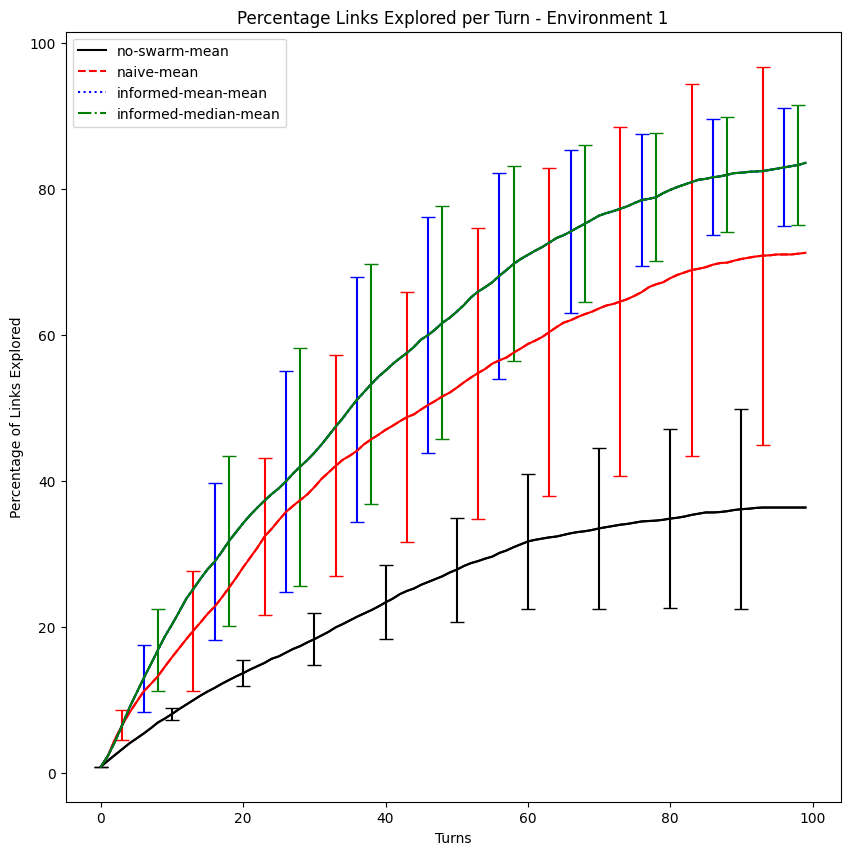

In [163]:
# Plot the results for environment 1
plot_pct_explored_results(results_6_1_1, swarm_types, 'Percentage Links Explored per Turn - Environment 1', 'Percentage of Links Explored')


## Analysis 6.1.2

This analysis will focus on the results of the simulations in simulation 6.2. The results will be analysed to determine the effect of the swarm control strategy on the percentage of links explored by the agents in the network at each turn.

### Results

In [118]:
sims = [no_swarm_env2, naive_swarm_env2, informed_mean_swarm_env2, informed_median_swarm_env2]
results_6_1_2 = environment_dataframe(swarm_types, sims, 'pct_links_explored')
results_6_1_2

,no-swarm-mean,no-swarm-min,no-swarm-max,no-swarm-std,naive-mean,naive-min,naive-max,naive-std,informed-mean-mean,informed-mean-min,informed-mean-max,informed-mean-std,informed-median-mean,informed-median-min,informed-median-max,informed-median-std
turn,,,,,,,,,,,,,,,,
0,0.178891,0.178891,0.178891,0.0,0.178891,0.178891,0.178891,0.0,0.178891,0.178891,0.178891,0.0,0.178891,0.178891,0.178891,0.0
1,0.357782,0.357782,0.357782,0.0,0.536673,0.357782,0.715564,0.122718,0.536673,0.357782,0.715564,0.122718,0.536673,0.357782,0.715564,0.122718
2,0.536673,0.536673,0.536673,0.0,1.061419,0.536673,1.431127,0.30608,1.025641,0.536673,1.431127,0.30535,1.025641,0.536673,1.431127,0.30535
3,0.691711,0.536673,0.715564,0.068221,1.514609,0.715564,2.325581,0.517449,1.502683,0.715564,2.146691,0.502029,1.502683,0.715564,2.146691,0.502029
4,0.84675,0.536673,0.894454,0.121867,1.920095,1.073345,3.220036,0.712645,2.039356,1.073345,2.862254,0.62857,2.039356,1.073345,2.862254,0.62857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,11.079308,0.894454,14.31127,4.53078,23.351222,11.270125,42.576029,10.8719,30.781157,17.710197,45.080501,8.057264,30.781157,17.710197,45.080501,8.057264
96,11.174717,0.894454,14.490161,4.583367,23.553965,11.270125,42.754919,10.965418,31.10316,18.067979,45.259392,8.026693,31.10316,18.067979,45.259392,8.026693
97,11.293977,0.894454,14.669052,4.637688,23.697078,11.270125,42.754919,11.000602,31.401312,18.246869,45.259392,8.01072,31.401312,18.246869,45.259392,8.01072


### Graphs

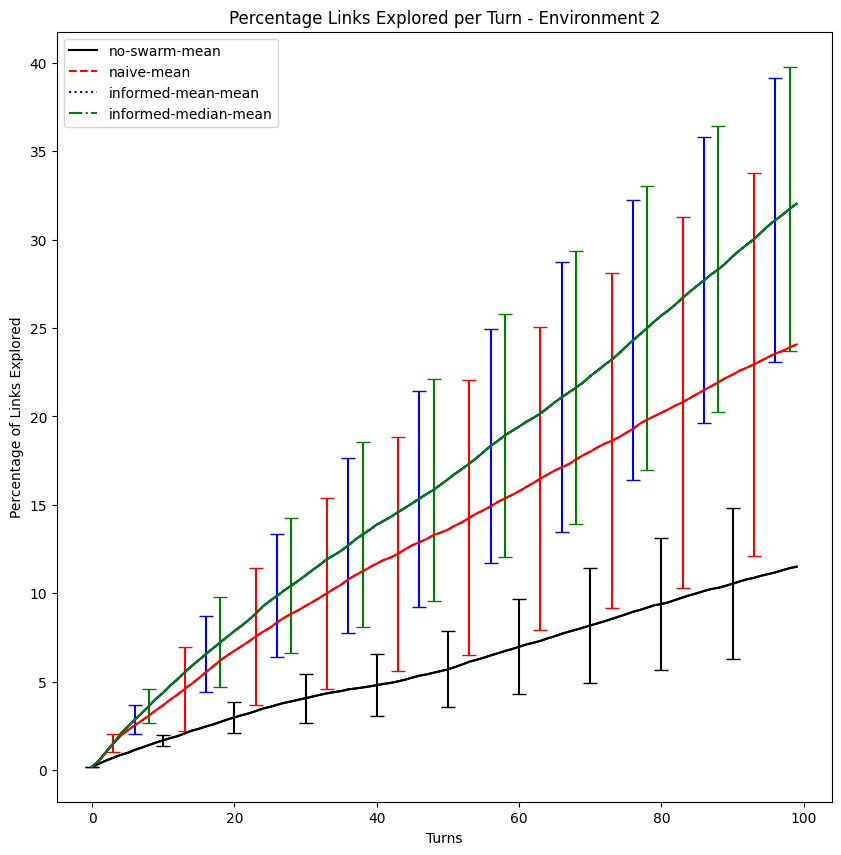

In [164]:
# Plot the results for environment 2
plot_pct_explored_results(results_6_1_2, swarm_types, 'Percentage Links Explored per Turn - Environment 2', 'Percentage of Links Explored')

## Analysis 6.1.3

This analysis will focus on the results of the simulations in simulation 6.3. The results will be analysed to determine the effect of the swarm control strategy on the percentage of links explored by the agents in the network at each turn.

### Results

In [119]:
sims = [no_swarm_env3, naive_swarm_env3, informed_mean_swarm_env3, informed_median_swarm_env3]
results_6_1_3 = environment_dataframe(swarm_types, sims, 'pct_links_explored')
results_6_1_3

,no-swarm-mean,no-swarm-min,no-swarm-max,no-swarm-std,naive-mean,naive-min,naive-max,naive-std,informed-mean-mean,informed-mean-min,informed-mean-max,informed-mean-std,informed-median-mean,informed-median-min,informed-median-max,informed-median-std
turn,,,,,,,,,,,,,,,,
0,0.02611,0.02611,0.02611,0.0,0.02611,0.02611,0.02611,0.0,0.02611,0.02611,0.02611,0.0,0.02611,0.02611,0.02611,0.0
1,0.052219,0.052219,0.052219,0.0,0.076588,0.052219,0.104439,0.014076,0.076588,0.052219,0.104439,0.014076,0.076588,0.052219,0.104439,0.014076
2,0.074848,0.052219,0.078329,0.009957,0.147955,0.078329,0.208877,0.045613,0.140992,0.078329,0.208877,0.040109,0.140992,0.078329,0.208877,0.040109
3,0.099217,0.078329,0.104439,0.011077,0.222802,0.104439,0.339426,0.078133,0.228024,0.104439,0.313316,0.066383,0.228024,0.104439,0.313316,0.066383
4,0.123586,0.104439,0.130548,0.011898,0.288947,0.130548,0.443864,0.105002,0.3255,0.156658,0.469974,0.096479,0.3255,0.156658,0.469974,0.096479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.671018,0.234987,2.29765,0.781127,4.563969,2.715405,7.180157,1.507394,5.820714,2.715405,9.765013,2.00464,5.820714,2.715405,9.765013,2.00464
96,1.690165,0.234987,2.32376,0.792831,4.607485,2.741514,7.232376,1.5157,5.876414,2.741514,9.765013,2.003719,5.876414,2.741514,9.765013,2.003719
97,1.707572,0.234987,2.32376,0.801952,4.656223,2.793734,7.284595,1.519855,5.932115,2.767624,9.791123,2.010228,5.932115,2.767624,9.791123,2.010228


### Graphs

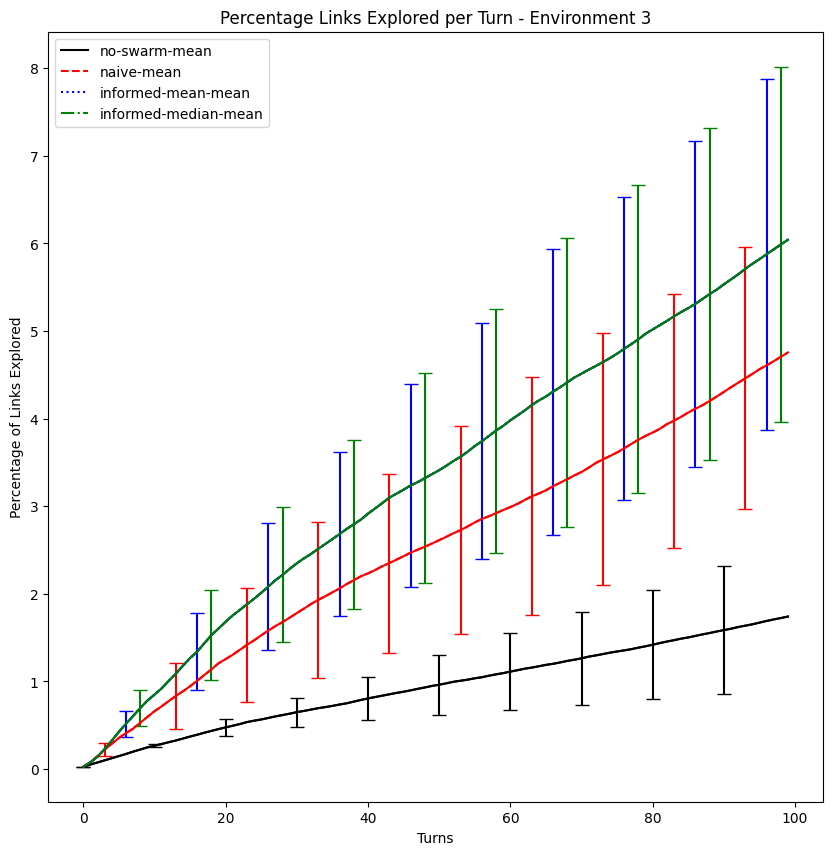

In [165]:
# Plot the results for environment 3
plot_pct_explored_results(results_6_1_3, swarm_types, 'Percentage Links Explored per Turn - Environment 3', 'Percentage of Links Explored')

## Analysis 6.2.1

This analysis will focus on the results of the simulations in simulation 6.1. The results will be analysed to determine the effect of the swarm control strategy on the novelty of the links explored by the agents in the network at each turn.

### Results

In [166]:
sims = [no_swarm_env1, naive_swarm_env1, informed_mean_swarm_env1, informed_median_swarm_env1]
results_6_2_1 = environment_dataframe(swarm_types, sims, 'link_novelty_score')
results_6_2_1

,no-swarm-mean,no-swarm-min,no-swarm-max,no-swarm-std,naive-mean,naive-min,naive-max,naive-std,informed-mean-mean,informed-mean-min,informed-mean-max,informed-mean-std,informed-median-mean,informed-median-min,informed-median-max,informed-median-std
turn,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
1,1.0,1.0,1.0,0.0,0.622222,0.5,0.75,0.095305,0.622222,0.5,0.75,0.095305,0.622222,0.5,0.75,0.095305
2,0.933333,0.0,1.0,0.322414,0.480952,0.25,0.6,0.114193,0.506667,0.25,0.666667,0.139505,0.506667,0.25,0.666667,0.139505
3,0.933333,0.0,1.0,0.322414,0.360238,0.2,0.5,0.104786,0.434683,0.2,0.625,0.119725,0.434683,0.2,0.625,0.119725
4,0.933333,0.0,1.0,0.322414,0.279974,0.125,0.375,0.084681,0.372063,0.166667,0.555556,0.109501,0.372063,0.166667,0.555556,0.109501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.013333,0.0,0.1,0.038136,0.02,0.0,0.1,0.042426,0.02,0.0,0.1,0.042426
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.1,0.042426,0.02,0.0,0.1,0.042426
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020741,0.0,0.111111,0.044866,0.020741,0.0,0.111111,0.044866


### Graphs

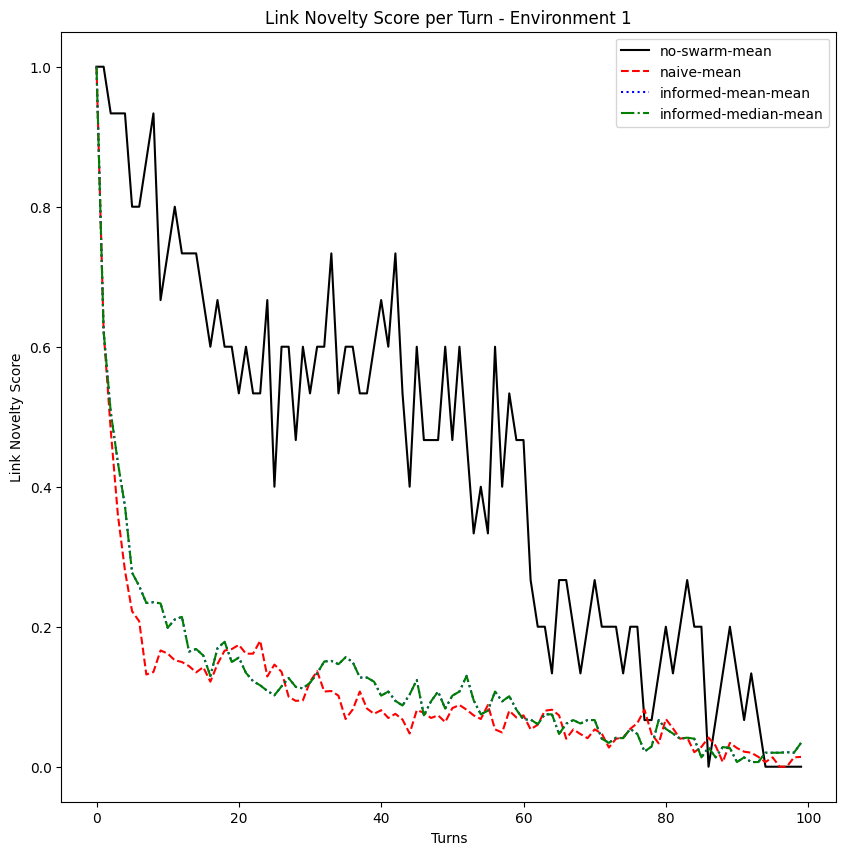

In [169]:
# Plot the results for environment 1
plot_link_novelty(results_6_2_1, swarm_types, 'Link Novelty Score per Turn - Environment 1', 'Link Novelty Score')

## Analysis 6.2.2

This analysis will focus on the results of the simulations in simulation 6.2. The results will be analysed to determine the effect of the swarm control strategy on the novelty of the links explored by the agents in the network at each turn.

### Results

In [170]:
sims = [no_swarm_env2, naive_swarm_env2, informed_mean_swarm_env2, informed_median_swarm_env2]
results_6_2_2 = environment_dataframe(swarm_types, sims, 'link_novelty_score')
results_6_2_2

,no-swarm-mean,no-swarm-min,no-swarm-max,no-swarm-std,naive-mean,naive-min,naive-max,naive-std,informed-mean-mean,informed-mean-min,informed-mean-max,informed-mean-std,informed-median-mean,informed-median-min,informed-median-max,informed-median-std
turn,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
1,1.0,1.0,1.0,0.0,0.65,0.5,0.75,0.088238,0.65,0.5,0.75,0.088238,0.65,0.5,0.75,0.088238
2,1.0,1.0,1.0,0.0,0.47754,0.333333,0.625,0.094453,0.542857,0.333333,0.666667,0.109164,0.542857,0.333333,0.666667,0.109164
3,0.866667,0.0,1.0,0.381356,0.37254,0.166667,0.625,0.154938,0.411164,0.2,0.571429,0.12983,0.411164,0.2,0.571429,0.12983
4,0.866667,0.0,1.0,0.381356,0.291534,0.111111,0.5,0.146291,0.383757,0.166667,0.5,0.093877,0.383757,0.166667,0.5,0.093877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.533333,0.0,1.0,0.499135,0.113333,0.0,0.3,0.098436,0.208889,0.0,0.5,0.150411,0.208889,0.0,0.5,0.150411
96,0.533333,0.0,1.0,0.499135,0.114815,0.0,0.3,0.10408,0.18,0.0,0.4,0.109735,0.18,0.0,0.4,0.109735
97,0.666667,0.0,1.0,0.477907,0.080741,0.0,0.2,0.078672,0.168148,0.0,0.4,0.126581,0.168148,0.0,0.4,0.126581


### Graphs

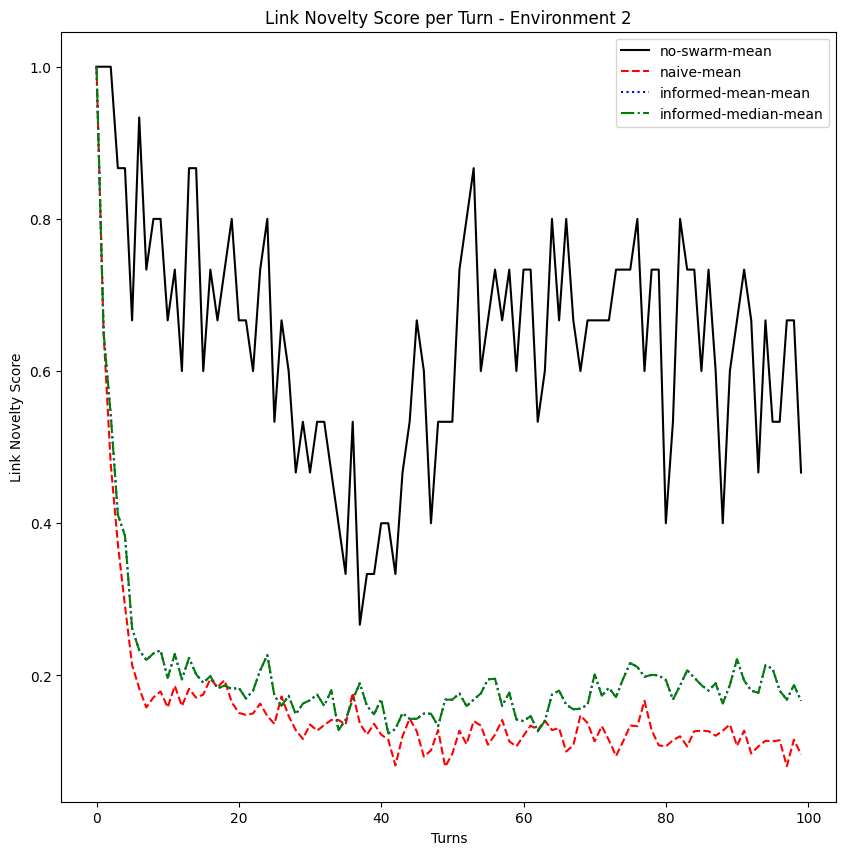

In [171]:
# Plot the results for environment 2
plot_link_novelty(results_6_2_2, swarm_types, 'Link Novelty Score per Turn - Environment 2', 'Link Novelty Score')

## Analysis 6.2.3

This analysis will focus on the results of the simulations in simulation 6.3. The results will be analysed to determine the effect of the swarm control strategy on the novelty of the links explored by the agents in the network at each turn.

### Results

In [172]:
sims = [no_swarm_env3, naive_swarm_env3, informed_mean_swarm_env3, informed_median_swarm_env3]
results_6_2_3 = environment_dataframe(swarm_types, sims, 'link_novelty_score')
results_6_2_3

,no-swarm-mean,no-swarm-min,no-swarm-max,no-swarm-std,naive-mean,naive-min,naive-max,naive-std,informed-mean-mean,informed-mean-min,informed-mean-max,informed-mean-std,informed-median-mean,informed-median-min,informed-median-max,informed-median-std
turn,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
1,1.0,1.0,1.0,0.0,0.65,0.5,0.75,0.073041,0.65,0.5,0.75,0.073041,0.65,0.5,0.75,0.073041
2,0.866667,0.0,1.0,0.381356,0.453175,0.25,0.625,0.129976,0.5,0.25,0.666667,0.152196,0.5,0.25,0.666667,0.152196
3,0.933333,0.0,1.0,0.322414,0.425873,0.2,0.625,0.141964,0.48373,0.25,0.625,0.118703,0.48373,0.25,0.625,0.118703
4,0.933333,0.0,1.0,0.322414,0.322751,0.2,0.444444,0.088706,0.440847,0.333333,0.6,0.099868,0.440847,0.333333,0.6,0.099868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.733333,0.0,1.0,0.455691,0.20963,0.0,0.4,0.111081,0.208148,0.1,0.4,0.094844,0.208148,0.1,0.4,0.094844
96,0.733333,0.0,1.0,0.455691,0.16963,0.1,0.3,0.081926,0.214074,0.0,0.4,0.117644,0.214074,0.0,0.4,0.117644
97,0.666667,0.0,1.0,0.477907,0.186667,0.1,0.3,0.07579,0.214074,0.1,0.4,0.109067,0.214074,0.1,0.4,0.109067


### Graphs

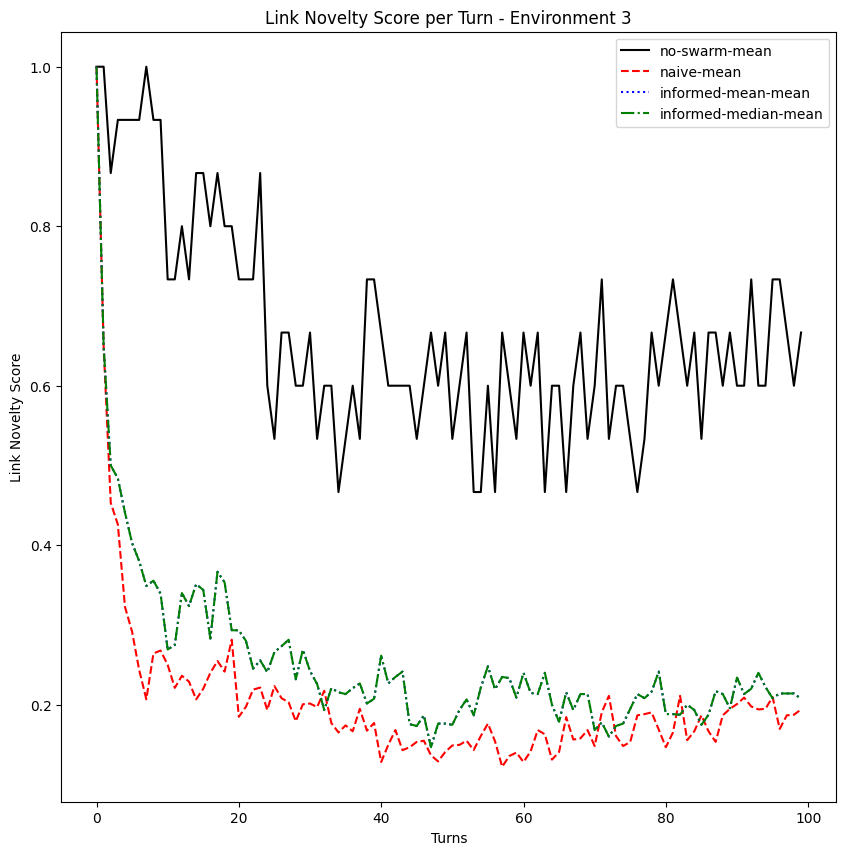

In [173]:
# Plot the results for environment 3
plot_link_novelty(results_6_2_3, swarm_types, 'Link Novelty Score per Turn - Environment 3', 'Link Novelty Score')

## Analysis 6.3.1

This analysis will focus on the results of the simulations in simulation 6.1. The results will be analysed to determine the effect of the swarm control strategy on the stability of the control strategy with respect to the starting position of the agents in the network.

### Results

In [262]:
sims = [no_swarm_env1, naive_swarm_env1, informed_mean_swarm_env1, informed_median_swarm_env1]
results_6_3_1 = start_node_results(swarm_types, sims)
results_6_3_1.sample(10)

,swarm_type,start_node,mean_pct_links_explored,mean_link_novelty_score
0,no-swarm,15,30.260504,0.620000
41,informed-mean,River,54.369748,0.116929
33,informed-mean,166,80.201681,0.140147
3,no-swarm,166,32.319328,0.620000
6,no-swarm,219,24.075630,0.400000
34,informed-mean,167,69.722689,0.120944
29,naive,2,45.285714,0.106480
22,naive,225,27.924370,0.059262
19,naive,167,69.226891,0.135917
9,no-swarm,243,24.243697,0.400000


In [241]:
# Test if the correlation between start node and mean pct_links_explored is significant
results_6_3_1.groupby('start_node').mean_pct_links_explored.agg(['mean', 'std', 'count'])

,mean,std,count
start_node,,,
1,46.216387,22.840837,4
131,50.285714,14.324965,4
15,46.409664,11.373875,4
166,66.239496,22.923151,4
167,55.250000,28.615800,4
2,43.292017,11.997611,4
203,56.220588,16.610651,4
219,36.743697,12.504860,4
225,36.781513,12.453906,4


### Graphs

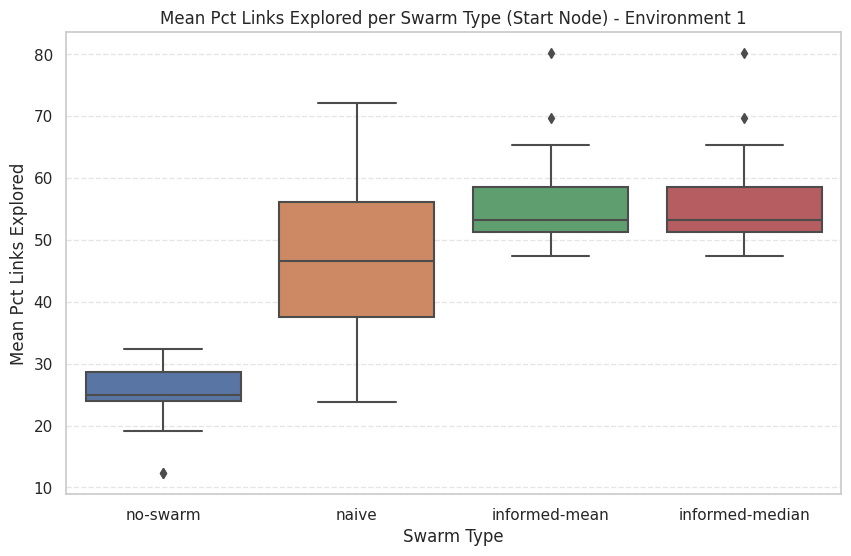

In [263]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='swarm_type', y='mean_pct_links_explored', data=results_6_3_1, ax=ax)
ax.set_title('Mean Pct Links Explored per Swarm Type (Start Node) - Environment 1')
ax.set_xlabel('Swarm Type')
ax.set_ylabel('Mean Pct Links Explored')
ax.grid(True, axis='y', alpha=0.5, linestyle='--')


## Analysis 6.3.2

This analysis will focus on the results of the simulations in simulation 6.2. The results will be analysed to determine the effect of the swarm control strategy on the stability of the control strategy with respect to the starting position of the agents in the network.

### Results

In [265]:
sims = [no_swarm_env2, naive_swarm_env2, informed_mean_swarm_env2, informed_median_swarm_env2]
results_6_3_2 = start_node_results(swarm_types, sims)
results_6_3_2.sample(10)

,swarm_type,start_node,mean_pct_links_explored,mean_link_novelty_score
45,informed-median,A2148,10.474061,0.174845
56,informed-median,A5183,16.699463,0.179306
40,informed-mean,A5178,21.370304,0.257619
6,no-swarm,A5153,6.779964,0.750000
31,informed-mean,A3007,19.046512,0.202619
9,no-swarm,A5175,7.073345,0.740000
26,naive,A5183,14.733453,0.168397
50,informed-median,A5078,26.949911,0.275381
18,naive,A5065,8.737030,0.122607
14,no-swarm,A5187,6.928444,0.760000


In [266]:
# Test if the correlation between start node and mean pct_links_explored is significant
results_6_3_2.groupby('start_node').mean_pct_links_explored.agg(['mean', 'std', 'count'])

,mean,std,count
start_node,,,
A2148,9.434258,1.447481,4
A3007,13.322898,8.252935,4
A3018,6.789356,3.961067,4
A5065,13.458855,7.059530,4
A5071,17.350626,6.629422,4
A5078,21.385957,10.371800,4
A5153,16.139088,6.756504,4
A5169,10.511181,3.022171,4
A5174,11.139088,4.841652,4


### Graphs

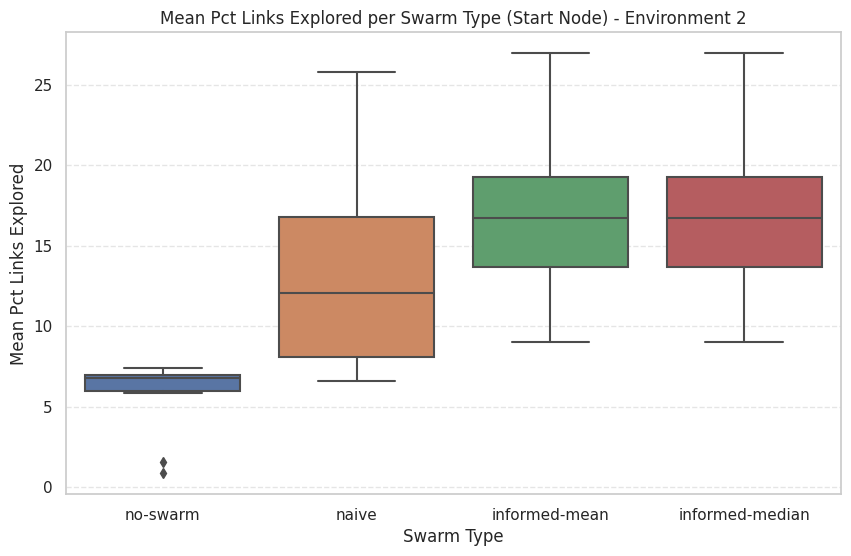

In [267]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='swarm_type', y='mean_pct_links_explored', data=results_6_3_2, ax=ax)
ax.set_title('Mean Pct Links Explored per Swarm Type (Start Node) - Environment 2')
ax.set_xlabel('Swarm Type')
ax.set_ylabel('Mean Pct Links Explored')
ax.grid(True, axis='y', alpha=0.5, linestyle='--')

## Analysis 6.3.3

This analysis will focus on the results of the simulations in simulation 6.3. The results will be analysed to determine the effect of the swarm control strategy on the stability of the control strategy with respect to the starting position of the agents in the network.

### Results

In [268]:
sims = [no_swarm_env3, naive_swarm_env3, informed_mean_swarm_env3, informed_median_swarm_env3]
results_6_3_3 = start_node_results(swarm_types, sims)
results_6_3_3.sample(10)

,swarm_type,start_node,mean_pct_links_explored,mean_link_novelty_score
23,naive,JUNCTION-45,2.949608,0.249472
14,no-swarm,JUNCTION-96,0.224804,0.090000
4,no-swarm,JUNCTION-38,1.029504,0.800000
50,informed-median,JUNCTION-39,2.833420,0.238730
42,informed-mean,JUNCTION-81,2.541253,0.199659
22,naive,JUNCTION-41,3.353264,0.257917
34,informed-mean,JUNCTION-38,2.833420,0.238730
41,informed-mean,JUNCTION-75,1.790339,0.128381
45,informed-median,JUNCTION-12,3.769452,0.291270
54,informed-median,JUNCTION-53,2.891384,0.220813


In [269]:
# Test if the correlation between start node and mean pct_links_explored is significant
results_6_3_3.groupby('start_node').mean_pct_links_explored.agg(['mean', 'std', 'count'])

,mean,std,count
start_node,,,
JUNCTION-12,2.861423,1.257975,4
JUNCTION-16,2.812272,1.131056,4
JUNCTION-20,2.428525,1.476793,4
JUNCTION-21,2.433747,1.471008,4
JUNCTION-38,2.246214,0.850842,4
JUNCTION-39,2.250000,0.843626,4
JUNCTION-40,2.330614,0.838806,4
JUNCTION-41,3.007507,1.305367,4
JUNCTION-45,2.891057,1.263426,4


### Graphs

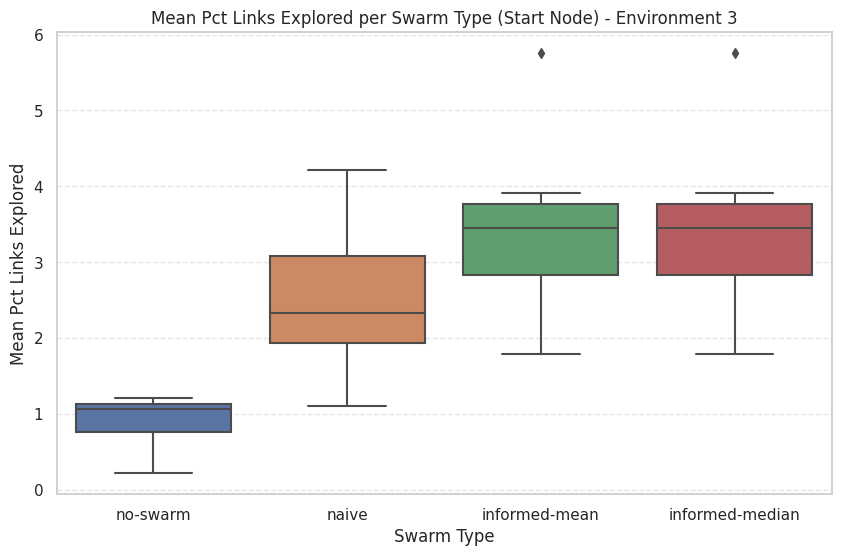

In [270]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='swarm_type', y='mean_pct_links_explored', data=results_6_3_3, ax=ax)
ax.set_title('Mean Pct Links Explored per Swarm Type (Start Node) - Environment 3')
ax.set_xlabel('Swarm Type')
ax.set_ylabel('Mean Pct Links Explored')
ax.grid(True, axis='y', alpha=0.5, linestyle='--')